## Impoting relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading the data, and seeing the training images

#### The dataset contains satellite images along with the annotated images that look like a map version of our satellite image. The satellite and the target images are both given in one single image side by side.

In [2]:
path = "../input/pix2pix-dataset/maps/maps/train/"
num_images = 1000

combined_images = sorted(glob(path + "*.jpg"))[:num_images]
    
images = np.zeros(shape=(len(combined_images), 256, 256, 3))
masks = np.zeros(shape=(len(combined_images), 256, 256, 3))

for idx, path in enumerate(combined_images):

    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    
    image = combined_image[:,:600,:]
    mask = combined_image[:,600:,:]

    images[idx] = (tf.image.resize(image,(256,256)))/255
    masks[idx] = (tf.image.resize(mask,(256,256)))/255


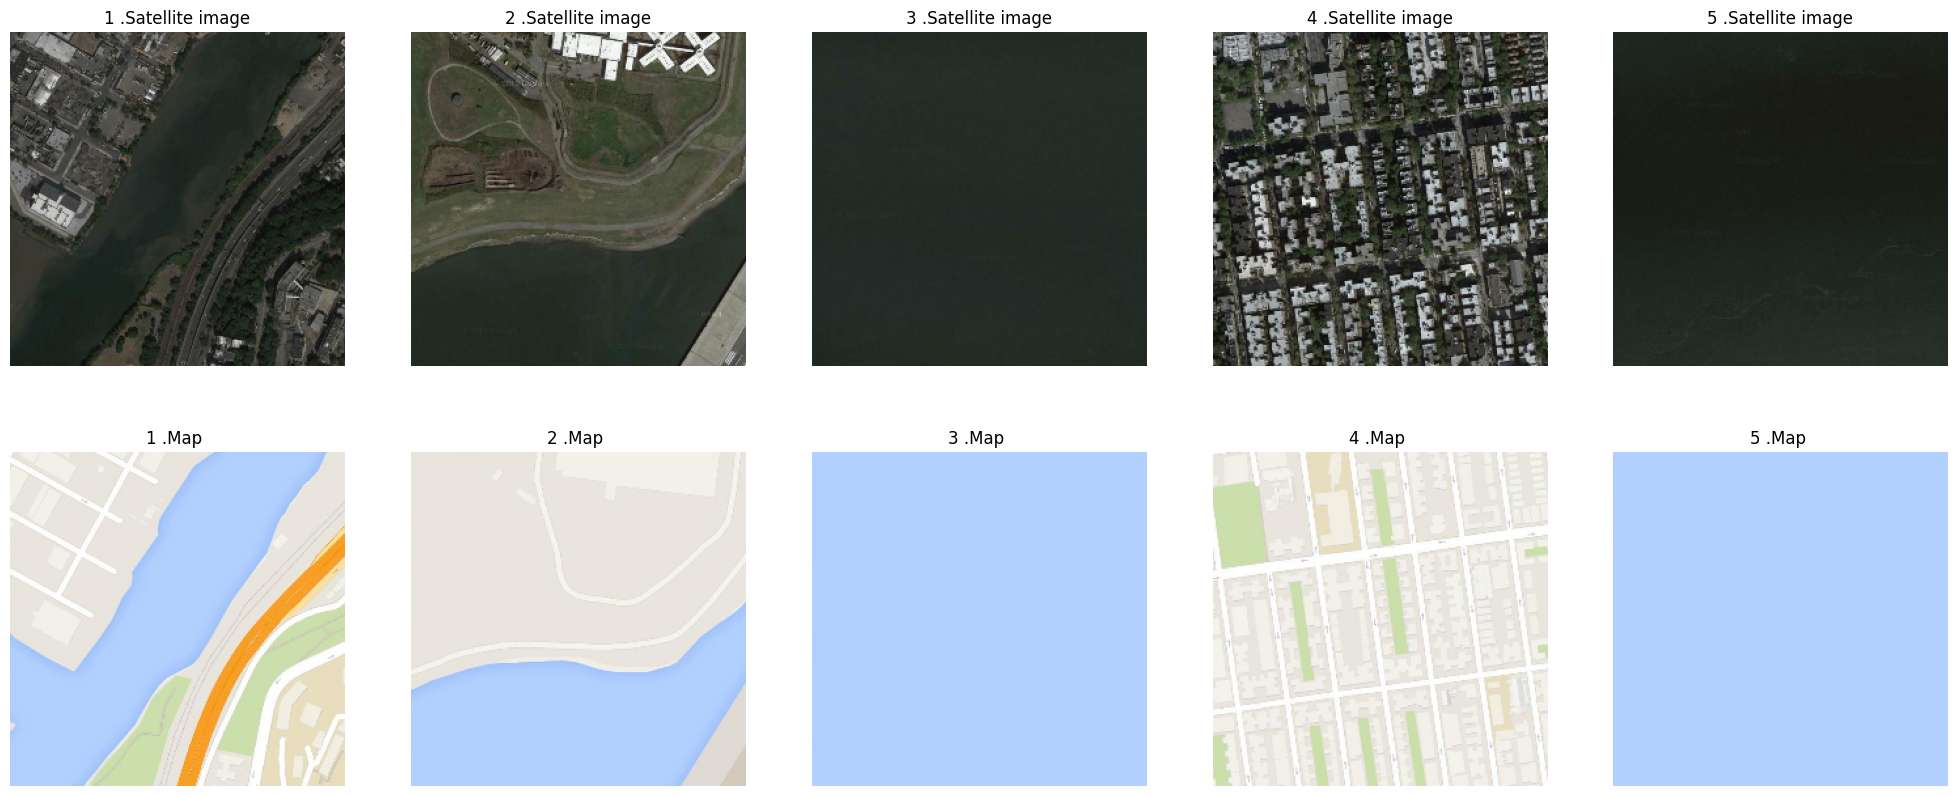

In [3]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    idx = np.random.randint(1,1000)
    image, mask = images[idx], masks[idx]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Satellite image")
    plt.axis("off")
    
    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Map ")
    plt.axis("off")
plt.show()

## Creating the GAN

### Creating the Generator of the model
#### The generator in the Pix2Pix GAN is a U-net

In [4]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def residual_block(input_tensor, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = concatenate([x, input_tensor])
    x = ReLU()(x)
    return x

def Generator():
    inputs = Input(shape=(256,256,3), name="InputLayer")

    encoder = [
        downscale(64),
        downscale(128),
        downscale(256),
        downscale(512),
        downscale(1024),
        downscale(1024),
    ]
    
   

    latent_space = downscale(1024)

    

    decoder = [
        upscale(1024),
        upscale(1024),
        upscale(512),
        upscale(256),
        upscale(128),
        upscale(64),
    ]
    
    x = inputs 
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)
   
    x = residual_block(x, 1024)
    x = latent_space(x)
    x = residual_block(x, 1024)
    
    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])
    
    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

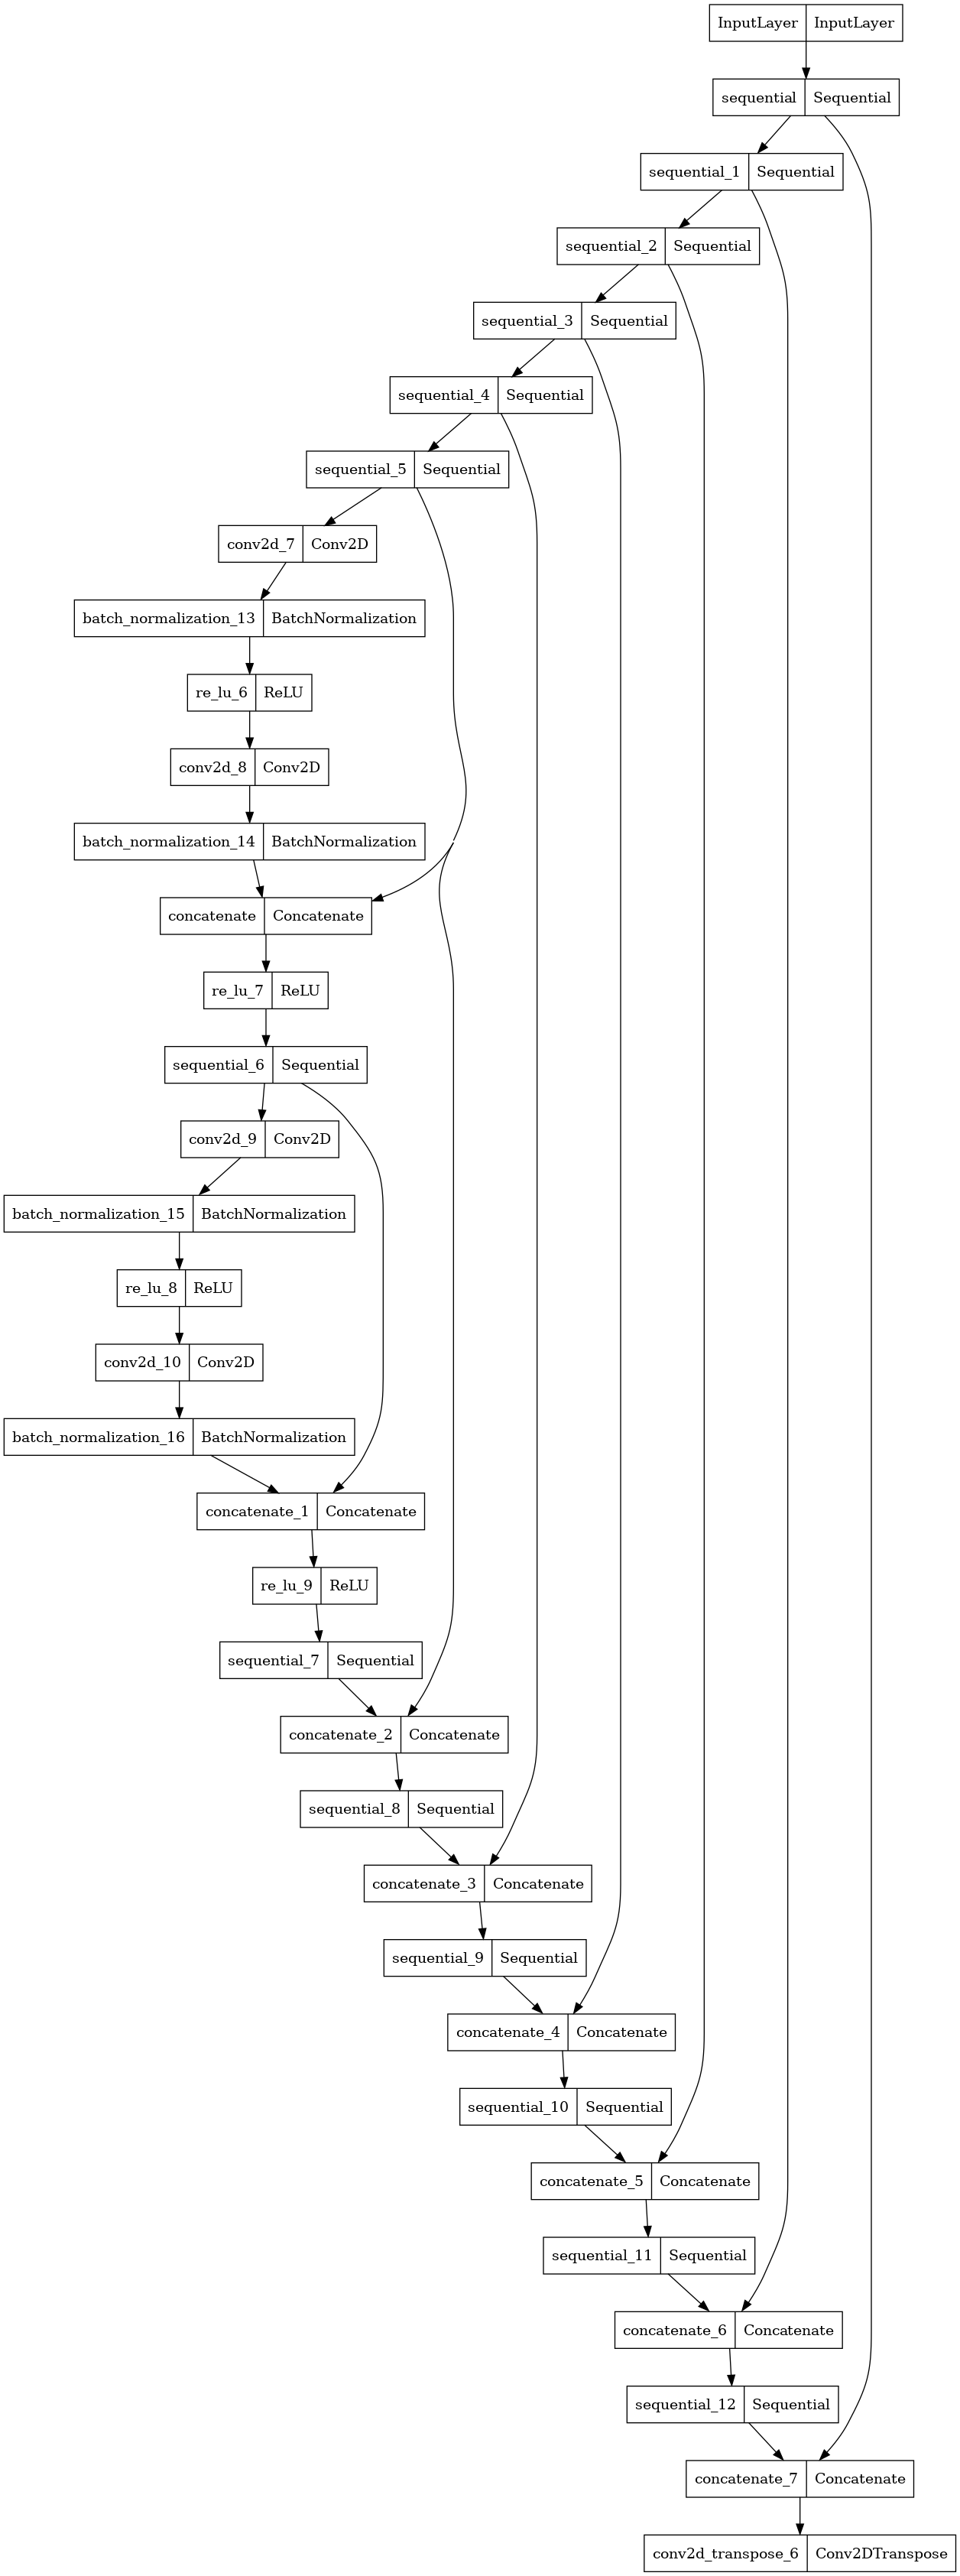

In [5]:
generator = Generator()
plot_model(generator)

### Creating the Discriminator of the model

#### The discrimintor in the Pix2Pix GAN is a Patch Gan

In [6]:
def Discriminator():
    image = Input(shape = (256,256,3), name = "ImageInput")
    target = Input(shape = (256,256,3), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)
        
    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

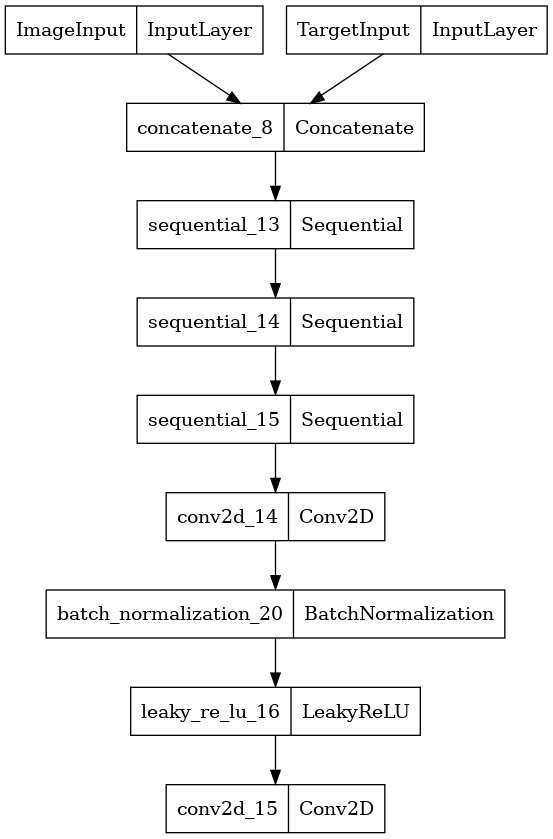

In [7]:
discriminator = Discriminator()
plot_model(discriminator)

## Creating loss functions, and training functions

#### The GAN is a bit different form other DL models, here we just cannot call the model.fit method to start the training process. The loss is passed in a non-sequential fashion here. And to calculate the loss, we make use of the Tensorflow's automatic differentiation engine, that calculates gradients and then we can use the optimizers to perform gradient descent.

In [8]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)
        
        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)
        
        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)
        
        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)
        
    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [9]:
def fit(data, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Current epoch: ", epoch+1)
    for image, mask in data:
      train_step(image, mask)
    print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")

In [10]:
sat_image, map_image = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
dataset = (sat_image,map_image)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

In [11]:
fit(data, 100)

Current epoch:  1
Time taken to complete the epoch 1 is 49.59 seconds 

Current epoch:  2
Time taken to complete the epoch 2 is 30.28 seconds 

Current epoch:  3
Time taken to complete the epoch 3 is 30.34 seconds 

Current epoch:  4
Time taken to complete the epoch 4 is 30.37 seconds 

Current epoch:  5
Time taken to complete the epoch 5 is 30.35 seconds 

Current epoch:  6
Time taken to complete the epoch 6 is 30.35 seconds 

Current epoch:  7
Time taken to complete the epoch 7 is 30.33 seconds 

Current epoch:  8
Time taken to complete the epoch 8 is 30.33 seconds 

Current epoch:  9
Time taken to complete the epoch 9 is 30.35 seconds 

Current epoch:  10
Time taken to complete the epoch 10 is 30.38 seconds 

Current epoch:  11
Time taken to complete the epoch 11 is 30.35 seconds 

Current epoch:  12
Time taken to complete the epoch 12 is 30.36 seconds 

Current epoch:  13
Time taken to complete the epoch 13 is 30.34 seconds 

Current epoch:  14
Time taken to complete the epoch 14 i

In [12]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(idx))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(idx))
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(idx))
        plt.axis('off')
        
        plt.show()
        
    

1/1 [==============================] - 1s 840ms/step


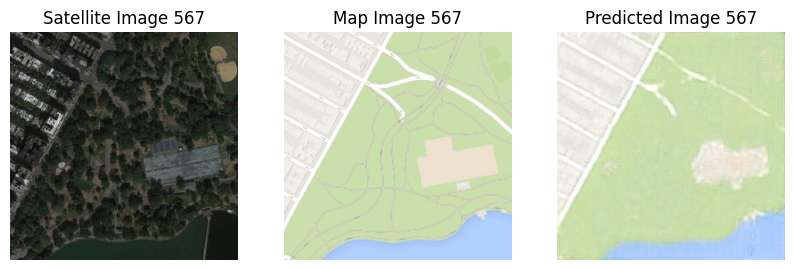

1/1 [==============================] - 0s 23ms/step


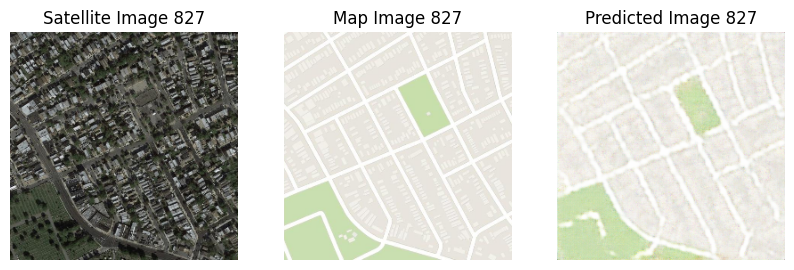

1/1 [==============================] - 0s 22ms/step


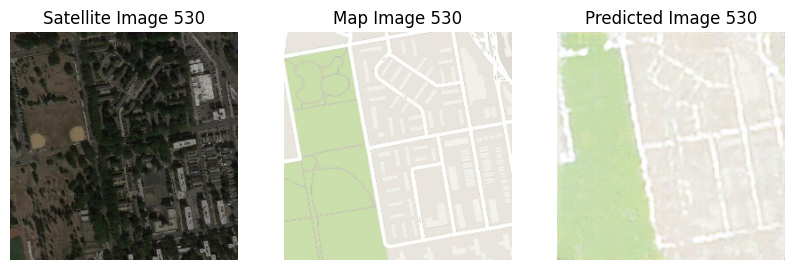

1/1 [==============================] - 0s 24ms/step


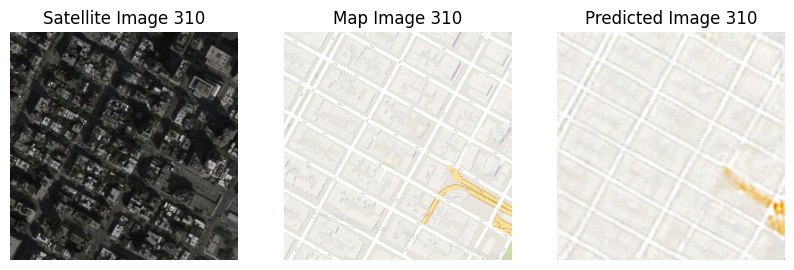

1/1 [==============================] - 0s 21ms/step


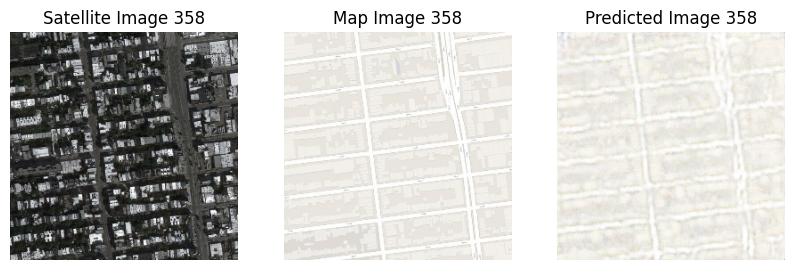

1/1 [==============================] - 0s 21ms/step


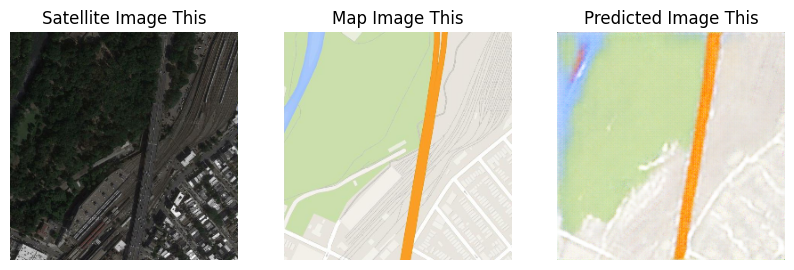

In [13]:
show_predictions(5)
image, mask = images[621], masks[621]
predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
plt.figure(figsize=(10,8))
        
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Satellite Image " + "This")
plt.axis('off')
        
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title("Map Image " + "This")
plt.axis('off')
        
plt.subplot(1,3,3)
plt.imshow(predicted)
plt.title("Predicted Image " + "This")
plt.axis('off')
        
plt.show()

In [14]:
import numpy as np
import math

def calculate_metrics(images, masks, generator, num_samples):
    mse_scores = []
    mae_scores = []

    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(np.expand_dims(image, axis=0))[0]
        
        # Calculate MSE
        mse_score = np.mean((mask - predicted) ** 2)
        mse_scores.append(mse_score)
        
        # Calculate MAE
        mae_score = np.mean(np.abs(mask - predicted))
        mae_scores.append(mae_score)
        
    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    
    return avg_mse, avg_mae

# Usage
num_samples = 100  # Number of samples to evaluate
avg_mse, avg_mae = calculate_metrics(images, masks, generator, num_samples)
print("Average MSE:", avg_mse * 100)
print("Average MAE:", avg_mae * 100)
print("Average RMSE:",math.sqrt(avg_mse) * 100)


1/1 [==============================] - 0s 20ms/step
Average MSE: 0.18005143565525186
Average MAE: 2.6460059947252352
Average RMSE: 4.243246818831682


In [15]:
import numpy as np
import math

def calculate_metrics(images, masks, generator, num_samples):
    mse_scores = []
    mae_scores = []

    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(np.expand_dims(image, axis=0))[0]
        
        # Calculate MSE
        mse_score = np.mean((mask - predicted) ** 2)
        mse_scores.append(mse_score)
        
        # Calculate MAE
        mae_score = np.mean(np.abs(mask - predicted))
        mae_scores.append(mae_score)
        
    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    
    return avg_mse, avg_mae

# Usage
num_samples = 100  # Number of samples to evaluate
avg_mse, avg_mae = calculate_metrics(images, masks, generator, num_samples)
print("Average MSE:", avg_mse * 100)
print("Average MAE:", avg_mae * 100)
print("Average RMSE:",math.sqrt(avg_mse) * 100)

1/1 [==============================] - 0s 19ms/step
Average MSE: 0.20670324781268545
Average MAE: 2.7672875655310247
Average RMSE: 4.546462886824058


#### The results are decent, one can train the model for more epochs to get better results, and tweak the architecture to get much better results.

In [16]:
generator.save("GAN_Sat_image_2_map.h5")